Parte 2: Clasificación 

   Usa el conjunto de datos de los vinos que puedes cargar con la función:  sklearn.datasets.load_wine En este caso, realizaremos una tarea de clasificación donde cada elemento a clasificar es un vino  que viene descrito por una serie de propiedades numéricas y que puede pertenecer a una clase  de vino entre tres posibles.  

In [1]:
import numpy as np
import sklearn
import statistics as stat
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_validate


np.random.seed(11)  

# conjunto de datos de las viviendas en California
# .data, .target, .feature_names, .DESCR, .target_names
wine = sklearn.datasets.load_wine()

# descripcion del conjunto
# print(wine.DESCR)

1) Describe el conjunto de datos tal y como se indica más arriba y extrae algunas conclusiones  de las variables y su distribución. 

    - Nombre del conjunto de datos
        Wine recognition dataset

    - Breve descripción del problema que describe
        Representar los resultados de un analisis quimico sobre vinos cultivados en una region de Italia por tres cultivadores distintos. Hay trece medidas distintas para comparar los vinos y se clasifican en tres clases.

    - Nombre y tipo de las variables
            - Alcohol
            - Malic acid
            - Ash
            - Alcalinity of ash  
            - Magnesium
            - Total phenols
            - Flavanoids
            - Nonflavanoid phenols
            - Proanthocyanins
            - Color intensity
            - Hue
            - OD280/OD315 of diluted wines
            - Proline

         todas las variables son de tipo numpy.float64

    - Estadísticos descriptivos de cada variable
        Summary Statistics:

        ============================= ==== ===== ======= =====
                                       Min   Max   Mean     SD
        ============================= ==== ===== ======= =====
        Alcohol:                      11.0  14.8    13.0   0.8
        Malic Acid:                   0.74  5.80    2.34  1.12
        Ash:                          1.36  3.23    2.36  0.27
        Alcalinity of Ash:            10.6  30.0    19.5   3.3
        Magnesium:                    70.0 162.0    99.7  14.3
        Total Phenols:                0.98  3.88    2.29  0.63
        Flavanoids:                   0.34  5.08    2.03  1.00
        Nonflavanoid Phenols:         0.13  0.66    0.36  0.12
        Proanthocyanins:              0.41  3.58    1.59  0.57
        Colour Intensity:              1.3  13.0     5.1   2.3
        Hue:                          0.48  1.71    0.96  0.23
        OD280/OD315 of diluted wines: 1.27  4.00    2.61  0.71
        Proline:                       278  1680     746   315
        ============================= ==== ===== ======= =====

In [2]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','w','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
    plt.show()

# Función para extraer columnas de una matriz: recibe una matriz y dos indices
# Devuelve una matriz con las columnas de los indices
def column(matrix, i, j):
    return np.array([np.array([row[i], row[j]]) for row in matrix])

2) Considera si debes normalizar o estandarizar las variables antes para usar un árbol de  decisión. Razona tu elección.  

Tras plotear los datos con y sin escalar, podemos observar que los datos escalados obtienen un menor indice de Silhouette en comparacion al valor de los datos sin escalar. Ademas si escalamos las variables los clusters no quedan divididos por lineas tan verticales.

Dado que sin escalar obtiene un indice de Silhouette mayor, no escalamos.)

SIN ESCALADO:


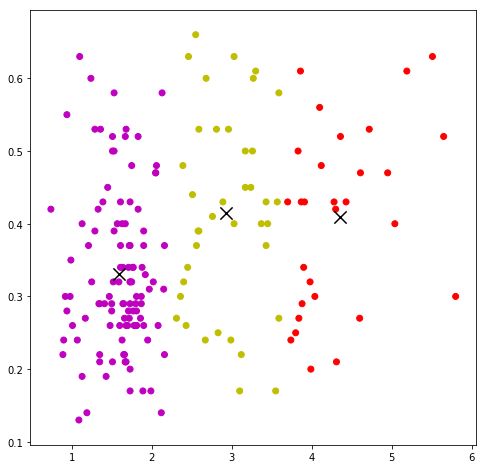

0.6086980543675791

CON ESCALADO:


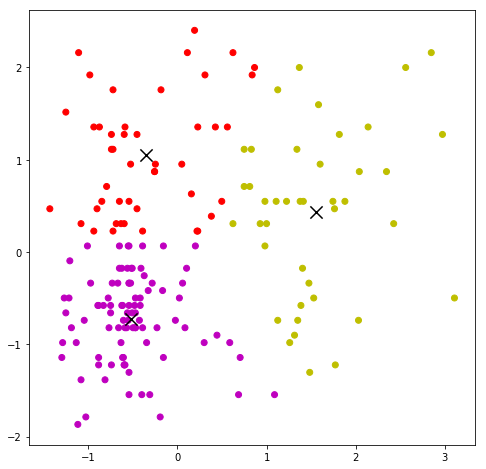

0.4482890923281011


In [3]:
# Copiamos a X las columnas 4 y 5 (Población y Ocupación Media)
X = column(wine.data, 1, 7)

#Declaramos un array para guardar los valores de silhouette y poder compararlos despues
silhouette = np.zeros(2)

# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=3)
km.fit(X)

#Ploteamos X sin escalar para compararlo despues con X escalado
print("SIN ESCALADO:")
plot_clusters(X, km.labels_, km.cluster_centers_)

silhouette[0] = silhouette_score(X, km.labels_) 
print(silhouette_score(X, km.labels_))
print()
#Ahora re-escalamos X y ploteamos de nuevo
scaler = StandardScaler()
XSCALED = scaler.fit_transform(X)

#Redefinimos k-means para plotearlo escalado
km = KMeans(init='random', n_clusters=3)
km.fit(XSCALED)

print("CON ESCALADO:")
plot_clusters(XSCALED, km.labels_, km.cluster_centers_)
   
silhouette[1] = silhouette_score(XSCALED, km.labels_) 
print(silhouette_score(XSCALED, km.labels_))

3) Configura una partición de los datos con un 30% para el conjunto de test y estratificando la  muestra. Analiza los resultados de entrenamiento y test que obtiene un árbol de decisión en función de la profundidad máxima del árbol. Pinta la evolución de la curva de aprendizaje.  Determina el valor óptimo de dicho parámetro de manera razonada.  

        Los valores de aprendizaje se estabilizan a partir de una profundidad de 2 niveles. Con un nivel de profundidad, los valores de aprendizaje son aproximade 0,6. El valor de aprendizaje de entrenamiento llega a su máximo en tres niveles de profundidad, mientras que el de valor de aprendizaje de prueba alanza su máximo en dos niveles de profundidad. A partir de sus máximos, ambos niveles se estabilizan y el valor de aprendizaje no vuelve a bajar ni a subir drásticamente.
        El valor óptimo para la profundidad máxima del árbol es de 2 niveles.

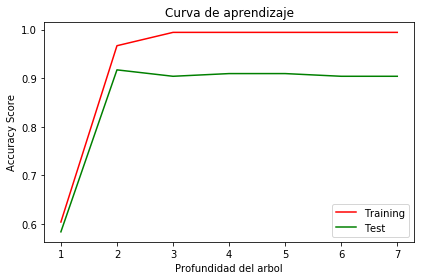

In [4]:
#Estratificacion
#Problema de clasificacion: Significa que la proporcion de clases en cada parte sea similar.

# Partimos el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3, random_state=0)

# Validación cruzada dividiendo el conjunto de datos en 5 partes (folds)
# cross_validate usa validación estratificada para problemas de clasificación binaria o multiclase
train_accuracy = []
test_accuracy = []

max_depths = range(1, 8)
for md in max_depths: 
    
    # Entrenar y validar
    clf = DecisionTreeClassifier(criterion="entropy",  # por defecto Gini pero podemos cambiar a entropía
                             max_depth=md,           # profundidad máxima del árbol
                             min_samples_split=5)  # mínimo de muestras en el nodo para seguir dividiéndolo
    clf = clf.fit(X_train, y_train)

    # Validación cruzada dividiendo el conjunto de datos en 5 partes (folds)
    # cross_validate usa validación estratificada para problemas de clasificación binaria o multiclase
    scores = cross_validate(clf, wine.data, wine.target, scoring='accuracy', cv=10, return_train_score=True)
    
    # Añadir puntuaciones a las listas
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Profundidad del arbol"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show() 




4) Pinta el árbol de decisión óptimo que has encontrado y analiza lo siguiente:

![title](treeOpt.png)
    a) Interpreta someramente la pregunta que se realiza en el nodo raíz y los nodos hijos resultantes. Hazlo tanto en el contexto de un problema de clasificación (¿qué clases ha clasificado mejor?), como en el del problema representado en el conjunto de datos (¿qué sentido tiene esa pregunta y la clasificación que infiere dentro del problema?). 
    
    La pregunta planteada por el nodo raíz distingue según la variable flavanoids. Las decisiones se llevan a otros dos nodos según si el valor de flavanoides es menor o igual a 1.575 o no. Si la pregunta planteada tiene respuesta verdadera, se distingue según la variable color_intensity; si la intensidad de color es menor o igual que 3.825 o no. Si la intensidad del color es menor o igual que 3.825, se concluye que la clase del vino es la 1. Por el contrario, si la intensidad es mayor que 3.825, la clasificación acaba en la clase 2.    
    En caso de que el valor de flavanoides sea superior a 1.575, se comprobará en el siguiente nivel si el valor de la variable proline es menor o igual que 724.5 o no. Si el valor de proline es menor o igual que 724.5, se concluye en que el vino pertenece a la clase 1. Si no, el vino pertenece a la clase 0.
    b)Analiza si hay variables que sirven para discriminar entre algunas clases
    Las variables flavanoids, que distingue entre la clase 2 y la clase 0; color_intensity, que distingue entre las clases 1 y 2; y proline, que distingue entre las clases 1 y 0 son las que discriminan en los dos primeros niveles del árbol.
    
    c)Analiza si hay variables del conjunto de datos que no se han usado. 
    Las variables Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Nonflavanoid phenols, Proanthocyanins, Hue, OD280/OD315 of diluted wines son las que no se utilizan para distinguir entre clases en el árbol de decisión.

In [5]:
# Utilizando profundidad 2 => configuración óptima
clf = DecisionTreeClassifier(criterion="entropy", 
                             splitter="best",
                             max_depth=2,
                             min_samples_split=2, 
                             max_leaf_nodes=None)
clf = clf.fit(wine.data, wine.target)

# exportar al fichero tree.dot
# dot -Tpng tree.dot -o tree.png
export_graphviz(clf, out_file='treeOpt.dot', 
                     feature_names=wine.feature_names,  
                     class_names=wine.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True) 

5) Pinta un árbol de decisión sub‐óptimo que sobreaprenda. Por ejemplo, el que se obtiene  para un nivel más de profundidad máxima. Identifica los nodos nuevos.
![title](treeMalo.png)


In [6]:
# Utilizando profundidad 11 => configuración sub-óptima
clf = DecisionTreeClassifier(criterion="entropy", 
                             splitter="best",
                             max_depth=11,
                             min_samples_split=2, 
                             max_leaf_nodes=None)
clf = clf.fit(wine.data, wine.target)

# exportar al fichero tree.dot
# dot -Tpng tree.dot -o tree.png
export_graphviz(clf, out_file='treeMalo.dot', 
                     feature_names=wine.feature_names,  
                     class_names=wine.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True) 

6) Crea la matriz de confusión de los datos de test. Analiza también los valores de “precision” y  “recall”  (exhaustividad)  para  cada  una  de  las  clases  (usa  para  ello  sklearn.metrics.classification_report).   

7) Configura un clasificador k‐NN para la misma partición de datos.   

    a) Determina si tiene sentido o no escalar los datos.   
    
    b) Encuentra el valor óptimo de k que no sobreaprenda.  
    
    c) Compara los resultados de precisión y exhaustividad de ese k‐NN óptimo con los que  obtiene el árbol de decisión.  